In [1]:
import numpy    as np
import pandas   as pd
import networkx as nx

import matplotlib.pyplot as plt

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import kneighbors_graph
from sklearn.metrics       import pairwise_distances


In [3]:
df = pd.read_csv("../data/processed/photometric_z2.5_sn_25.csv")
df.describe()

,Z,PSFMAG_u,PSFMAG_g,PSFMAG_r,PSFMAG_i,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,SN_MEDIAN_ALL,...,K_g,K_r,K_i,M_u,M_g,M_r,M_i,u_g,g_r,r_i
count,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,...,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000,7298.000000
mean,1.138728,18.144534,17.872423,17.695044,17.565628,0.156711,0.120526,0.084277,0.062922,32.255556,...,-0.408867,-0.173439,-0.142357,-25.439366,-25.686871,-26.063430,-26.202573,0.247505,0.376559,0.139144
std,0.669820,0.751794,0.662493,0.618687,0.636729,0.096885,0.074476,0.052091,0.038913,6.796239,...,0.200819,0.199274,0.194424,1.933796,1.888503,1.872146,1.879929,0.230750,0.165269,0.101036
min,0.004153,14.247252,14.388747,14.459476,14.084700,0.017132,0.013349,0.009235,0.006862,25.002308,...,-0.816864,-0.455711,-0.398128,-29.783957,-29.880597,-30.286828,-30.476412,-4.891333,-0.232115,-3.280621
25%,0.536489,17.688221,17.467079,17.315396,17.190430,0.085192,0.065432,0.045869,0.034211,27.191056,...,-0.570073,-0.324743,-0.346856,-26.827658,-27.102444,-27.480433,-27.632001,0.126207,0.285317,0.083524
50%,1.107271,18.161829,17.923318,17.744710,17.625888,0.130728,0.100506,0.070412,0.052516,30.148148,...,-0.409984,-0.293603,-0.141941,-25.977119,-26.207394,-26.555546,-26.694335,0.204084,0.349801,0.133505
75%,1.693000,18.615182,18.306258,18.107947,17.985466,0.205886,0.158152,0.110760,0.082790,35.453175,...,-0.324973,0.042944,0.020170,-24.413951,-24.646785,-24.997003,-25.090485,0.311446,0.431586,0.187788
max,2.498000,24.634121,25.070984,21.162504,23.304535,0.555323,0.432704,0.299343,0.223591,76.683449,...,0.008939,0.286896,0.249128,-13.053094,-13.338057,-13.505810,-13.797227,5.559997,5.470358,0.916723


In [ ]:
# --- Selección y escalado
features = ["M_u","M_g","M_r","M_i","u_g","g_r","r_i"]
X_scaled = StandardScaler().fit_transform(df[features])

# --- Distancias y similitud gaussiana
D = pairwise_distances(X_scaled, metric="euclidean")

# usar mediana sin la diagonal (evita sesgo por ceros)
sigma = np.median(D[D > 0]) / 2.0
W_dense = np.exp(-(D**2) / (2 * sigma**2))
np.fill_diagonal(W_dense, 0)

# --- Sparsificar con kNN y simetrizar
k = 8
A = kneighbors_graph(X_scaled, n_neighbors=k, mode="connectivity", include_self=False)
A = A.maximum(A.T)  # simetrizar kNN

# umbral opcional para eliminar pesos ínfimos antes de aplicar la máscara
W_dense[W_dense < 0.05] = 0

# aplicar máscara kNN: mantiene solo aristas entre vecinos
W_sparse = A.multiply(W_dense)          # resultado: matriz dispersa con pesos
W_sparse.eliminate_zeros()

# --- Construir grafo ponderado
G = nx.from_scipy_sparse_array(W_sparse, edge_attribute="weight")
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")


In [37]:
G = nx.from_numpy_array(W)
print(f"Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}")

Nodos: 7298, Aristas: 16554548


c:\Users\jm_ra\Documents\Proyectos\network_analisis\DR16Q\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


KeyboardInterrupt: 

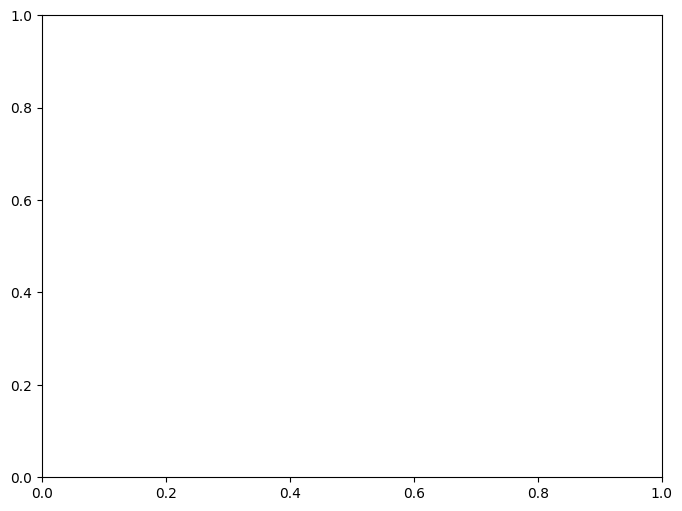

In [38]:
import umap

# Embedding 2D
embedding = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42).fit_transform(X_scaled)

# Guardar en nodos
for i, (x, y) in enumerate(embedding):
    G.nodes[i]["pos"] = (x, y)
    G.nodes[i]["Z"] = df.loc[i, "Z"]

# Visualizar
pos = nx.get_node_attributes(G, "pos")
z = np.array([G.nodes[i]["Z"] for i in G.nodes])

plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, alpha=0.05)
plt.scatter(
    [p[0] for p in pos.values()],
    [p[1] for p in pos.values()],
    c=z, cmap="viridis", s=8, alpha=0.7
)
plt.colorbar(label="Redshift Z")
plt.title("Grafo de similitud de cuásares (UMAP projection)")
plt.axis("off")
plt.show()

In [33]:
degrees = np.array([deg for _, deg in G.degree()])
print(f"Grado medio: {degrees.mean():.2f} ± {degrees.std():.2f}")
print(f"Número de componentes: {nx.number_connected_components(G)}")


Grado medio: 10.40 ± 1.68
Número de componentes: 1


In [34]:
import community as community_louvain
import matplotlib.cm as cm

Nº de comunidades: 23
Tamaño de las 10 mayores:
 0     564
10    487
11    481
4     428
21    388
20    386
17    375
13    355
1     338
7     328
Name: count, dtype: int64


C:\Users\jm_ra\AppData\Local\Temp\ipykernel_22960\3441995946.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", max(n_comm, 3))  # tab20 da hasta 20 colores; para más, puedes usar tab20 + hsv


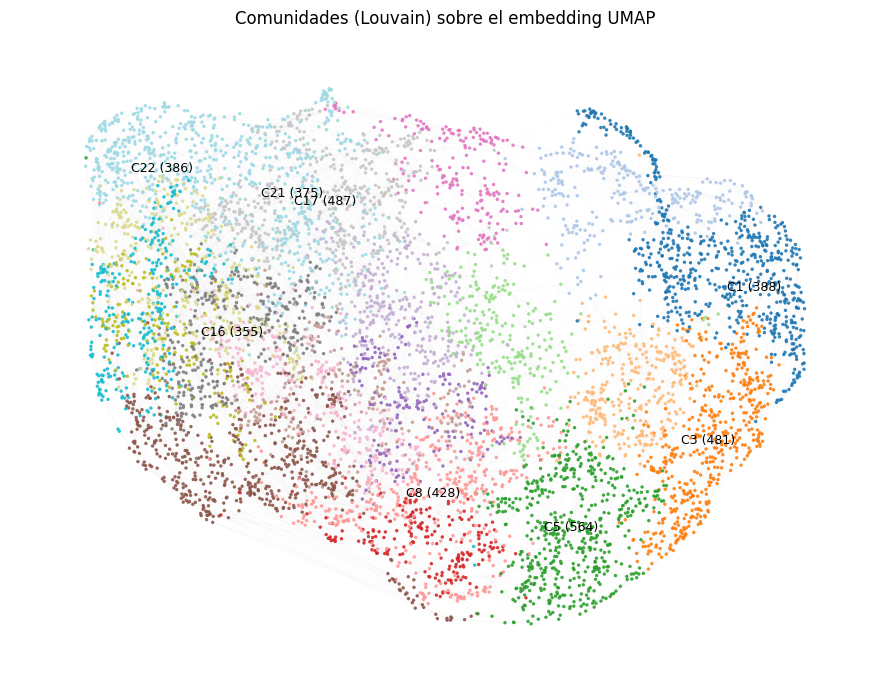

In [35]:
partition = community_louvain.best_partition(
    G,
    weight="weight" if nx.get_edge_attributes(G, "weight") else None,
    resolution=1.0,          # ↑ sube para más comunidades, ↓ para menos
    random_state=42
)
nx.set_node_attributes(G, partition, "comm")

# 2) Estadísticas rápidas
comm_id = np.array([partition[i] for i in G.nodes()])
sizes = pd.Series(comm_id).value_counts().sort_values(ascending=False)
print(f"Nº de comunidades: {sizes.size}")
print("Tamaño de las 10 mayores:\n", sizes.head(10))

# 3) Reordenar colores por <Z> (opcional, solo para que el color tenga sentido físico)
order = (
    pd.Series(z)
    .groupby(comm_id)
    .mean()
    .sort_values()
    .index
)
remap = {old:new for new, old in enumerate(order)}
comm_ord = np.array([remap[c] for c in comm_id])

# 4) Paleta discreta con suficientes colores
n_comm = sizes.size
cmap = cm.get_cmap("tab20", max(n_comm, 3))  # tab20 da hasta 20 colores; para más, puedes usar tab20 + hsv

# 5) Dibujo
plt.figure(figsize=(9,7))
nx.draw_networkx_edges(G, pos, alpha=0.05, width=0.3, edge_color="lightgray")

xy = np.array([pos[i] for i in G.nodes()])
plt.scatter(xy[:,0], xy[:,1],
            c=comm_ord, cmap=cmap, s=6, alpha=0.9, linewidths=0)

plt.title("Comunidades (Louvain) sobre el embedding UMAP")
plt.axis("off")

# 6) Etiquetar centroides de las comunidades más grandes
top_k = min(8, n_comm)
for cid in sizes.index[:top_k]:
    idx = np.where(comm_id == cid)[0]
    cx, cy = xy[idx].mean(axis=0)
    plt.text(cx, cy, f"C{remap[cid]} ({len(idx)})", ha="center", va="center", fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
import numpy as np, pandas as pd, networkx as nx
from community import modularity  # python-louvain

# Asumo: df (tus datos), G (grafo), 'comm' en atributos de nodos, pos y z ya calculados
comm = pd.Series(nx.get_node_attributes(G, "comm")).sort_index()
df_comm = df.copy()
df_comm["comm"] = comm.values

# Modularidad
part_dict = dict(comm.items())
Q = modularity(part_dict, G, weight="weight" if nx.get_edge_attributes(G,"weight") else None)
print(f"Modularidad (Louvain): {Q:.3f}")

# Resumen por comunidad
cols = ["Z","u_g","g_r","r_i","M_u","M_g","M_r","M_i","SN_MEDIAN_ALL"]
summary = (df_comm
           .groupby("comm")[cols]
           .agg(["count","mean","std"])
           .sort_values(("Z","mean")))
print(summary.head(10))


Modularidad (Louvain): 0.809
         Z                       u_g                       g_r            \
     count      mean       std count      mean       std count      mean   
comm                                                                       
8      212  0.118628  0.043517   212  0.542044  0.438567   212  0.563756   
21     388  0.228348  0.081593   388  0.154565  0.125964   388  0.321360   
9      267  0.255104  0.141153   267  0.579837  0.298281   267  0.651544   
11     481  0.345648  0.120169   481  0.141155  0.078998   481  0.207723   
6      306  0.433723  0.139304   306  0.228538  0.307816   306  0.406226   
0      564  0.622731  0.191155   564  0.168763  0.099057   564  0.282569   
19     248  0.756029  0.215651   248  0.251455  0.122884   248  0.438892   
22     201  0.915312  0.191293   201  0.063486  0.050569   201  0.279295   
4      428  0.977531  0.310469   428  0.171031  0.071839   428  0.368364   
3      185  1.002660  0.243517   185  0.120309  0.062868   

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

features = ["M_u","M_g","M_r","M_i","u_g","g_r","r_i"]
X = df[features].values
Z = df[["Z"]].values

# Residualizar cada feature respecto a Z (modelo lineal simple)
X_res = np.empty_like(X)
for j in range(X.shape[1]):
    lr = LinearRegression().fit(Z, X[:,j])
    X_res[:,j] = X[:,j] - lr.predict(Z).ravel()

# Escalar y reconstruir kNN + UMAP + Louvain con X_res


In [26]:
from sklearn.metrics import normalized_mutual_info_score as NMI

# comm_a, comm_b son arrays alineados por nodo
score = NMI(comm_a, comm_b)
print("NMI:", score)


NameError: name 'comm_a' is not defined

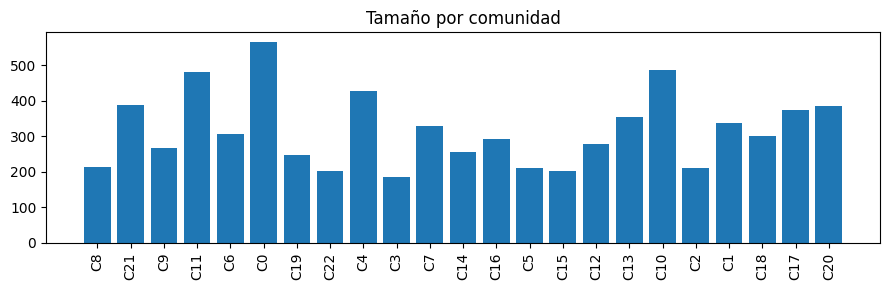

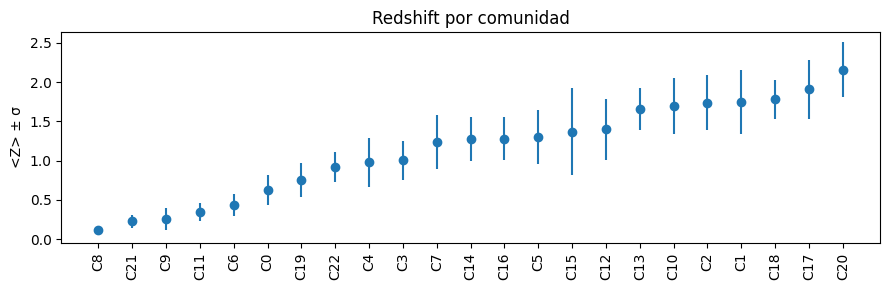

In [27]:
import matplotlib.pyplot as plt

sizes = df_comm["comm"].value_counts().sort_index()
z_mean = df_comm.groupby("comm")["Z"].mean().reindex(sizes.index)
z_std  = df_comm.groupby("comm")["Z"].std().reindex(sizes.index)

order = z_mean.sort_values().index
plt.figure(figsize=(9,3))
plt.bar(range(len(order)), sizes.loc[order].values)
plt.xticks(range(len(order)), [f"C{i}" for i in order], rotation=90)
plt.title("Tamaño por comunidad"); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3))
plt.errorbar(range(len(order)), z_mean.loc[order], yerr=z_std.loc[order], fmt="o")
plt.xticks(range(len(order)), [f"C{i}" for i in order], rotation=90)
plt.ylabel("<Z> ± σ"); plt.title("Redshift por comunidad"); plt.tight_layout(); plt.show()


In [28]:
df_out = df.copy()
df_out["comm"] = comm.values
df_out.to_csv("../results/tables/dr16q_with_communities.csv", index=False)